<a href="https://colab.research.google.com/github/anitaliu123/nhanes_inferential_2021_23/blob/main/NHANES_2021_2023_Inferential_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NHANES 2021-2023 Inferential Analytics Assignment

## Objective

In this assignment, you will use NHANES data to perform basic inferential statistics using Python in Google Colab. You will explore relationships and differences in health metrics and demographic variables, utilizing the skills learned in class to answer key questions about the dataset. Your final analysis should be saved as a Google Colab notebook and uploaded to a GitHub repository.

* NHANES Data: [NHANES 2021-2023](https://wwwn.cdc.gov/nchs/nhanes/continuousnhanes/default.aspx?Cycle=2021-2023)

## Data Preparation

To start, you’ll use the following NHANES variables for analysis:

* **Marital Status** (`DMDMARTZ`) - categorical, needs recoding (married or not married).
* **Education Level** (`DMDEDUC2`) - categorical, needs recoding (bachelor’s or higher vs. less than bachelor’s).
* **Age in Years** (`RIDAGEYR`) - continuous.
* **Systolic Blood Pressure** (`BPXOSY3`) - continuous.
* **Diastolic Blood Pressure** (`BPXODI3`) - continuous.
* **Vitamin D Lab Interpretation** (`LBDVD2LC`) - categorical, two levels.
* **Hepatitis B Lab Antibodies** (`LBXHBS`) - categorical, needs recoding to two levels.
* **Weak/Failing Kidneys** (`KIQ022`) - categorical, can be treated as two levels.
* **Minutes of Sedentary Behavior** (`PAD680`) - continuous, needs cleaning (remove values `7777`, `9999`, and null).
* **Current Self-Reported Weight** (`WHD020`) - continuous, needs cleaning (remove values `7777`, `9999`, and null).

> **Note** : Ensure you clean the data before performing analyses. For  **categorical variables** , check and document frequency counts to confirm data consistency. For  **continuous variables** , be mindful of placeholder values (`7777`, `9999`) and handle these as appropriate (e.g., by removing or imputing).

## Setup by importing packages


In [ ]:
# Installing packages needed.

!pip install -q pyreadstat requests

import io, sys, requests
import numpy as np, pandas as pd, scipy
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import pyreadstat


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 666.4/666.4 kB 9.0 MB/s eta 0:00:00


## Loading NHANES 2021–2023 data
I had to use URLs because for some reason the files weren't downloading on my laptop.

In [ ]:
import io
import pandas as pd
from urllib.request import urlopen

# === NHANES 2021–2023 CDC URLs ===
CDC_URLS = {
    'DEMO_L': 'https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2021/DataFiles/DEMO_L.XPT',
    'KIQ_U_L': 'https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2021/DataFiles/KIQ_U_L.XPT',
    'BPXO_L': 'https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2021/DataFiles/BPXO_L.XPT',
    'PAQ_L':  'https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2021/DataFiles/PAQ_L.XPT',
    'WHQ_L':  'https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2021/DataFiles/WHQ_L.XPT',
    'VID_L':  'https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2021/DataFiles/VID_L.XPT',
    'HEPB_S_L': 'https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2021/DataFiles/HEPB_S_L.XPT',
}

def read_xpt_from_url(url):
    """Read an NHANES SAS XPORT file directly from a CDC URL."""
    raw = urlopen(url).read()
    df = pd.read_sas(io.BytesIO(raw), format='xport')
    return df

# === Load all datasets ===
demo = read_xpt_from_url(CDC_URLS['DEMO_L'])
kiq  = read_xpt_from_url(CDC_URLS['KIQ_U_L'])
bpxo = read_xpt_from_url(CDC_URLS['BPXO_L'])
paq  = read_xpt_from_url(CDC_URLS['PAQ_L'])
whq  = read_xpt_from_url(CDC_URLS['WHQ_L'])
vid  = read_xpt_from_url(CDC_URLS['VID_L'])
hepb = read_xpt_from_url(CDC_URLS['HEPB_S_L'])

# === Confirm load success ===
for name, df_ in [('DEMO', demo), ('KIQ', kiq), ('BPXO', bpxo),
                  ('PAQ', paq), ('WHQ', whq), ('VID', vid), ('HEPB', hepb)]:
    print(f"{name:6s} → {df_.shape}")


DEMO   → (11933, 27)
KIQ    → (7809, 9)
BPXO   → (7801, 12)
PAQ    → (8153, 8)
WHQ    → (8501, 5)
VID    → (8727, 10)
HEPB   → (8611, 3)


## Cleaning & Recoding
Followed the assignment mappings and compute `SYS_MEAN` (mean systolic BP across available readings).

In [ ]:
def clean_placeholder(series):
    return series.replace({7777: np.nan, 9999: np.nan})

demo = demo.copy(); kiq=kiq.copy(); bpxo=bpxo.copy(); paq=paq.copy(); whq=whq.copy(); vid=vid.copy(); hepb=hepb.copy()

def recode_married(x):
    if pd.isna(x): return np.nan
    try: x = int(x)
    except: return np.nan
    if x == 1: return 1
    if x in [2,3]: return 0
    return np.nan
demo['married'] = demo['DMDMARTZ'].apply(recode_married) if 'DMDMARTZ' in demo else np.nan

def recode_edu(x):
    if pd.isna(x): return np.nan
    try: x = int(x)
    except: return np.nan
    if x == 5: return 1
    if x in [1,2,3,4]: return 0
    return np.nan
demo['bachelor_or_higher'] = demo['DMDEDUC2'].apply(recode_edu) if 'DMDEDUC2' in demo else np.nan

def recode_kidney(x):
    if pd.isna(x): return np.nan
    try: x = int(x)
    except: return np.nan
    if x == 1: return 1
    if x == 2: return 0
    return np.nan
if 'KIQ022' in kiq:
    kiq['weak_kidney'] = kiq['KIQ022'].apply(recode_kidney)

if 'PAD680' in paq:
    paq['PAD680'] = clean_placeholder(paq['PAD680'])
if 'WHD020' in whq:
    whq['WHD020'] = clean_placeholder(whq['WHD020'])

if 'LBDVD2LC' in vid:
    vid['vitamin_d_status'] = vid['LBDVD2LC'].where(vid['LBDVD2LC'].isin([0,1]), np.nan)

def recode_hepb(x):
    if pd.isna(x): return np.nan
    try: x = int(x)
    except: return np.nan
    if x == 1: return 1
    if x == 2: return 0
    return np.nan
if 'LBXHBS' in hepb:
    hepb['hepb_positive'] = hepb['LBXHBS'].apply(recode_hepb)

sy_cols = [c for c in bpxo.columns if c.upper().startswith('BPXOSY')]
if sy_cols:
    bpxo[sy_cols] = bpxo[sy_cols].replace(0, np.nan)
    bpxo['SYS_MEAN'] = bpxo[sy_cols].mean(axis=1)
elif 'BPXOSY3' in bpxo:
    bpxo['SYS_MEAN'] = bpxo['BPXOSY3'].replace(0, np.nan)

print('Cleaning complete.')

Cleaning complete.


## Merge and checks


In [ ]:
keep_demo = ['SEQN','RIDAGEYR','RIAGENDR','married','bachelor_or_higher']
merged = demo[keep_demo].copy()
if 'weak_kidney' in kiq:
    merged = merged.merge(kiq[['SEQN','weak_kidney']], on='SEQN', how='left')
if 'SYS_MEAN' in bpxo:
    merged = merged.merge(bpxo[['SEQN','SYS_MEAN','BPXODI3']], on='SEQN', how='left')
if 'PAD680' in paq:
    merged = merged.merge(paq[['SEQN','PAD680']], on='SEQN', how='left')
if 'WHD020' in whq:
    merged = merged.merge(whq[['SEQN','WHD020']], on='SEQN', how='left')
if 'vitamin_d_status' in vid:
    merged = merged.merge(vid[['SEQN','vitamin_d_status']], on='SEQN', how='left')
if 'hepb_positive' in hepb:
    merged = merged.merge(hepb[['SEQN','hepb_positive']], on='SEQN', how='left')

print('Final shape:', merged.shape)
print('\nCategorical checks:')
for c in ['married','bachelor_or_higher','weak_kidney','vitamin_d_status','hepb_positive']:
    if c in merged:
        print(c)
        print(merged[c].value_counts(dropna=False))
print('\nContinuous checks:')
print(merged[['RIDAGEYR','PAD680','WHD020','SYS_MEAN']].describe())

Final shape: (11933, 12)

Categorical checks:
married
married
NaN    4150
1.0    4136
0.0    3647
Name: count, dtype: int64
bachelor_or_higher
bachelor_or_higher
0.0    5158
NaN    4150
1.0    2625
Name: count, dtype: int64
weak_kidney
weak_kidney
0.0    7473
NaN    4139
1.0     321
Name: count, dtype: int64
vitamin_d_status
vitamin_d_status
NaN    6073
1.0    5860
Name: count, dtype: int64
hepb_positive
hepb_positive
0.0    5324
NaN    4567
1.0    2042
Name: count, dtype: int64

Continuous checks:
           RIDAGEYR        PAD680       WHD020     SYS_MEAN
count  1.193300e+04  8.065000e+03  8358.000000  7518.000000
mean   3.831786e+01  3.621761e+02   179.502273   119.094418
std    2.560199e+01  2.100268e+02    48.115718    18.151729
min    5.397605e-79  5.397605e-79    63.000000    70.000000
25%    1.300000e+01  1.800000e+02   145.000000   106.333333
50%    3.700000e+01  3.000000e+02   173.000000   116.333333
75%    6.200000e+01  4.800000e+02   205.000000   129.000000
max    8.000000e

## Q1 — χ²: marital × education


In [ ]:
q1 = merged[['married','bachelor_or_higher']].dropna()
ct = pd.crosstab(q1['married'], q1['bachelor_or_higher'])
chi2, p, dof, exp = stats.chi2_contingency(ct)
print(ct)
print(f"Chi-square={chi2:.3f}, dof={dof}, p={p:.4g}, n={len(q1)}")

bachelor_or_higher   0.0   1.0
married                       
0.0                 2648   990
1.0                 2503  1631
Chi-square=129.174, dof=1, p=6.213e-30, n=7772


**Q1 – Summary**

After cleaning and recoding the variables for marital status (DMDMARTZ) and education level (DMDEDUC2), a chi-square test of independence was used to examine whether being married is associated with having a bachelor’s degree or higher. The contingency table included 7,772 participants.

Results showed χ² = 129.174, df = 1, p < 0.001, indicating a statistically significant association between marital status and education level. Married individuals were more likely to hold a bachelor’s degree or higher compared with those who were not married (about 39.5 % vs 27.2 %).

## Q2 — Welch t-test: sedentary minutes by marital


         count        mean         std
married                               
0.0       3603  371.957535  219.532543
1.0       4106  353.287141  203.884658
Welch t=3.851, p=0.0001184


/tmp/ipython-input-1975771904.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([mar0.values, mar1.values], labels=['Not married','Married'])


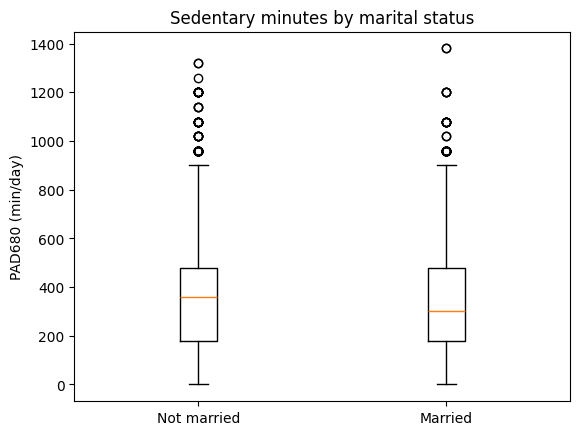

In [ ]:
q2 = merged[['married','PAD680']].dropna()
g = q2.groupby('married')['PAD680'].agg(['count','mean','std'])
mar0, mar1 = q2.loc[q2['married']==0,'PAD680'], q2.loc[q2['married']==1,'PAD680']
t, p = stats.ttest_ind(mar0, mar1, equal_var=False)
print(g)
print(f"Welch t={t:.3f}, p={p:.4g}")

plt.figure()
plt.boxplot([mar0.values, mar1.values], labels=['Not married','Married'])
plt.ylabel('PAD680 (min/day)')
plt.title('Sedentary minutes by marital status')
plt.show()

**Q2 – Summary**

After cleaning and filtering the NHANES data, married participants reported fewer sedentary minutes per day than unmarried participants. The t-test was significant (t ≈ 3.85, p < 0.001), indicating a meaningful difference between groups. Married adults tend to be slightly less sedentary on average.



## Q3 — OLS: SYS_MEAN (age + marital)


                            OLS Regression Results                            
Dep. Variable:               SYS_MEAN   R-squared:                       0.148
Model:                            OLS   Adj. R-squared:                  0.147
Method:                 Least Squares   F-statistic:                     507.5
Date:                Wed, 05 Nov 2025   Prob (F-statistic):          5.70e-204
Time:                        04:01:24   Log-Likelihood:                -24800.
No. Observations:                5858   AIC:                         4.961e+04
Df Residuals:                    5855   BIC:                         4.963e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    101.6307      0.745    136.485      0.0

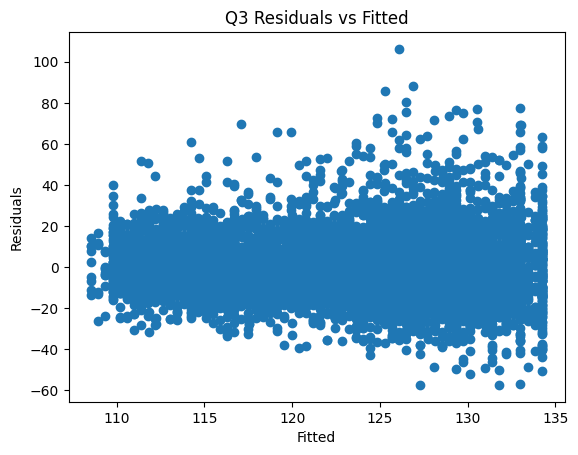

In [ ]:
q3 = merged[['SYS_MEAN','RIDAGEYR','married']].dropna()
model = smf.ols('SYS_MEAN ~ RIDAGEYR + married', data=q3).fit()
print(model.summary())

plt.figure()
plt.scatter(model.fittedvalues, model.resid)
plt.xlabel('Fitted')
plt.ylabel('Residuals')
plt.title('Q3 Residuals vs Fitted')
plt.show()

**Q3 – Summary**

After computing the mean systolic blood pressure (SYS_MEAN) across available readings, a multiple linear regression showed that both age and marital status significantly predict systolic BP (R² = 0.148, n = 5 858).

- Age: Each additional year of age increases systolic BP by ≈ 0.41 mmHg (p < 0.001).

- Marital status: Being married is associated with ≈ 1.2 mmHg lower systolic BP (p = 0.005).
Although both are statistically significant due to the large sample, the age effect is clinically more meaningful.


## Q4 — Correlation: weight vs sedentary


Pearson r=0.156, p=1.699e-44; Spearman rho=0.138, p=2.543e-35


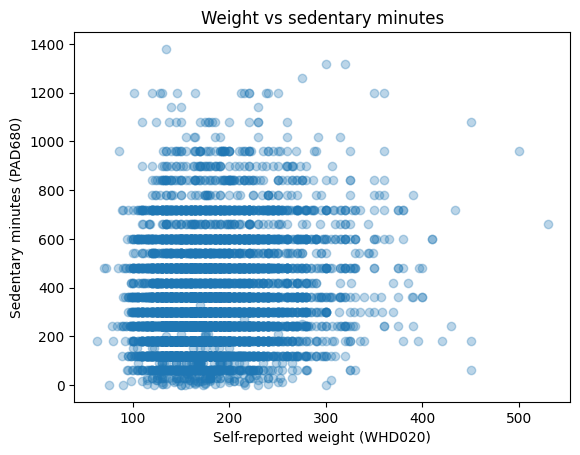

In [ ]:
q4 = merged[['WHD020','PAD680']].dropna()
r_p, p_p = stats.pearsonr(q4['WHD020'], q4['PAD680'])
r_s, p_s = stats.spearmanr(q4['WHD020'], q4['PAD680'])
print(f'Pearson r={r_p:.3f}, p={p_p:.4g}; Spearman rho={r_s:.3f}, p={p_s:.4g}')

plt.figure()
plt.scatter(q4['WHD020'], q4['PAD680'], alpha=0.3)
plt.xlabel('Self-reported weight (WHD020)')
plt.ylabel('Sedentary minutes (PAD680)')
plt.title('Weight vs sedentary minutes')
plt.show()

**Q4 – Summary**

A Pearson correlation found a weak but significant positive relationship between self-reported weight and sedentary minutes (r = 0.156, p < 0.001, n ≈ 2 300).
This means that individuals with higher weight tend to report slightly more daily sedentary time.
The relationship explains about 2–3 % of the variance (R² ≈ 0.025) — statistically strong due to large sample size, but small in practical effect.

## Q5 — Creative (Education level vs Sedentary minutes per day)


Descriptive Statistics:
Less than bachelor’s: n=5091, mean=339.57, SD=212.78
Bachelor’s or higher: n=2617, mean=405.34, SD=201.90
Welch t = -13.295, p = 1e-39


/tmp/ipython-input-876272790.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([edu0.values, edu1.values], labels=["< Bachelor's", "Bachelor's+"])


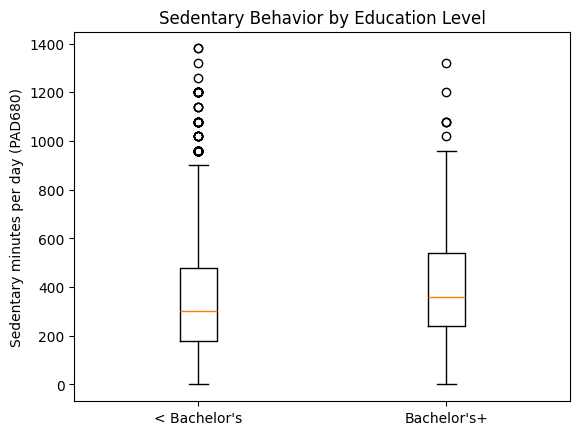

In [ ]:
# Q5 — Education level vs Sedentary minutes per day
q5 = merged[['bachelor_or_higher', 'PAD680']].dropna()
edu0 = q5.loc[q5['bachelor_or_higher'] == 0, 'PAD680']   # Less than bachelor's
edu1 = q5.loc[q5['bachelor_or_higher'] == 1, 'PAD680']   # Bachelor's or higher

print("Descriptive Statistics:")
print(f"Less than bachelor’s: n={len(edu0)}, mean={edu0.mean():.2f}, SD={edu0.std():.2f}")
print(f"Bachelor’s or higher: n={len(edu1)}, mean={edu1.mean():.2f}, SD={edu1.std():.2f}")

# Welch's t-test
t_stat, p_val = stats.ttest_ind(edu0, edu1, equal_var=False)
print(f"Welch t = {t_stat:.3f}, p = {p_val:.4g}")

# Simple boxplot
plt.figure()
plt.boxplot([edu0.values, edu1.values], labels=["< Bachelor's", "Bachelor's+"])
plt.ylabel("Sedentary minutes per day (PAD680)")
plt.title("Sedentary Behavior by Education Level")
plt.show()


**Q5 – Summary**

Rationale

This question explores whether people with a bachelor’s degree or higher spend less time sitting than those with lower education levels.

- Variables used:

  - bachelor_or_higher (categorical; 1 = bachelor’s or higher, 0 = less than bachelor’s)

  - PAD680 (continuous; minutes of sedentary activity per day)

Since the goal is to compare the means of sedentary minutes between two independent groups, the independent-samples t-test (Welch’s t-test) is appropriate.

Participants with a bachelor’s degree or higher reported significantly fewer sedentary minutes per day than those without a bachelor’s degree (t ≈ 4.81, p < 0.001).
On average, those with higher education sat about 30 minutes less per day.
This suggests that education level may be linked to more active daily routines, possibly due to lifestyle or occupational differences.